In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.express as px # for visualization 
import plotly.graph_objs as go 
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.io as pio
pyo.init_notebook_mode(connected = True)
pio.renderers.default = "png"

import os
import zipfile
import HelperFunctions as hf

from sklearn import tree

sns.set_palette('Set2')


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days

## Content

[Data Structure](#2.-Data-Structure)
- [Calendar](#2.1-Calendar)
- [Sale](#2.2-Sales)
- [Sell Price](#2.3-Sell-Prices)
- [Summary](#Summary)


[Combine Data](#3.-Combine-Data)

- Information of Variable



[By Item](#4.-By-item)
 - [Average sales between items](#4.1-Average-Sales-between-items)

 - [Distribution-of-total-sales-by-category](#4.2-Distribution-of-total-sales-by-category)
 
 - [Distribution-of-average-weekday--sales-by-category](#4.4-Distribution-of-average-weekday--sales-by-category)
 



[By Store](#5.-Sales-by-Store)

  - [Total-sales-between-all-the-stores](#5.1-Total-sales-between-all-the-stores)
  
  - [Total-sales-by-Category-between-all-the-stores](#5.2-Total-sales-by-Category-between-all-the-stores)
  
  - [Total-Daily-Sales-Trend-by-Category-between-all-the-stores](#5.3-Total-Daily-Sales-Trend-by-Category-between-all-the-stores) 


[By Snap](#6.-Sale-vs-Snap)


[Event](#7、Sales-by-Event)


[Top 10 Items](#8.-Top-10-Items-across-the-stores)


[By Depart](#9、Department)


By State


By Price


[Correlation](#10.-Correlation)


## Refer

- https://www.kaggle.com/anyexiezouqu/eda-chinese 
- https://www.kaggle.com/holoong9291/eda-for-m5-en
- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling#3.-Melting-the-data


# 1. Download the Data

In [2]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


Couldn't find program: 'bash'


In [3]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

fetch_walmat_data()

os.listdir('./data')

['calendar.csv',
 'm5-forecasting-accuracy.zip',
 'reduced.csv',
 'sales_train_evaluation.csv',
 'sales_train_validation.csv',
 'sample_submission.csv',
 'sell_prices.csv']

# 2. Data Structure

## 2.1 Calendar

In [4]:
calendar = hf.load_calendar_data()


In [5]:
calendar.shape


(1969, 14)

In [6]:
calendar.head(10)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [7]:
calendar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Type Casting

In [8]:
def typeCastCalendar(calendar):
    # month, wdays are small numbers and snap_CA, snap_TX, and snap_WI are just booleans
    calendar[["month", 'wday', "snap_CA", "snap_TX", "snap_WI"]]= calendar[["month", 'wday', "snap_CA", "snap_TX", "snap_WI"]].astype("int8")

    calendar[['wm_yr_wk', 'year']] = calendar[['wm_yr_wk', 'year']].astype('int16')

    calendar[['date']] = calendar[['date']].astype('datetime64')

    calendar[['weekday', "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = calendar[['weekday', "event_name_1", "event_type_1", "event_name_2", "event_type_2"]].astype('category')
    
    return calendar

typeCastCalendar(calendar)

calendar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(5), datetime64[ns](1), int16(2), int8(5), object(1)
memory usage: 60.1+ KB


### Date range

In [9]:
np.min(calendar['date']), np.max(calendar['date'])


(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [10]:
calendar['year'].unique()


array([2011, 2012, 2013, 2014, 2015, 2016], dtype=int16)

In [11]:
calendar['weekday'].unique()


['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
Categories (7, object): ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [12]:
calendar['d'].unique()


array(['d_1', 'd_2', 'd_3', ..., 'd_1967', 'd_1968', 'd_1969'],
      dtype=object)

In [13]:
wm_yr_wk = calendar['wm_yr_wk'].unique()

wm_yr_wk[:10], wm_yr_wk[-10:], len(calendar['wm_yr_wk'].unique())


(array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
        11110], dtype=int16),
 array([11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620,
        11621], dtype=int16),
 282)

### Event Type/Name

In [14]:
# Event Type

pd.concat([calendar['event_type_1'], calendar['event_type_2']], axis=0).unique()


array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [15]:
# Event Name

pd.concat([calendar['event_name_1'], calendar['event_name_2']], axis=0).unique()


array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

## 2.2 Sales

In [16]:
df_sales = hf.load_sales_train_validation_data()


In [17]:
df_sales.shape


(30490, 1919)

In [18]:
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [19]:
df_sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Type Casting

In [20]:
def typeCastSales(data):
    data.iloc[:, 6:] = data.iloc[:, 6:].astype("int16")
    return data

df_sales = typeCastSales(df_sales)

df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1913), object(6)
memory usage: 112.6+ MB


In [21]:
np.any(df_sales.isna()) # no missing value


False

In [22]:

item_len = len(df_sales['item_id'].unique())

print(f'{item_len} individual items in total')


3049 individual items in total


In [23]:
# select one item ranndomly, each item is sold in 10 stores across 3 states
df_sales[df_sales['item_id'] == 'HOBBIES_1_010']


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2
3058,HOBBIES_1_010_CA_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_2,CA,0,0,1,1,...,0,1,1,0,0,0,0,1,3,1
6107,HOBBIES_1_010_CA_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_3,CA,1,0,2,0,...,2,0,0,0,2,0,1,2,2,1
9156,HOBBIES_1_010_CA_4_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_4,CA,2,0,1,0,...,0,0,0,0,0,0,0,0,1,1
12205,HOBBIES_1_010_TX_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,1,0,1,1,0,0,0,1,0,1
15254,HOBBIES_1_010_TX_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_2,TX,0,2,0,1,...,0,0,1,0,2,0,1,0,0,1
18303,HOBBIES_1_010_TX_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_3,TX,1,0,0,1,...,2,1,2,2,0,0,0,1,0,0
21352,HOBBIES_1_010_WI_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_1,WI,1,2,0,0,...,1,0,0,0,2,0,0,0,1,2
24401,HOBBIES_1_010_WI_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_2,WI,0,0,0,1,...,0,0,0,1,1,0,0,0,1,2
27450,HOBBIES_1_010_WI_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_3,WI,0,2,0,0,...,1,0,0,0,1,0,0,1,1,0


### Distribution of Product Categories

In [24]:
# category_num = df_sales.groupby('cat_id')['id'].count()
# category_num = pd.DataFrame({
#     'Category': category_num.index,
#     'Count': category_num.values/(np.sum(category_num.values))
# })

# fig = px.bar(category_num, 
#              x='Category', y='Count', 
#              width=600, height=320, title='Total Product Distribution by Category')
# fig.update_layout(xaxis={'categoryorder':'total descending'})
# fig.show()


## 2.3 Sell Prices

In [25]:
df_sell_price = hf.load_sell_price_data()


In [26]:
df_sell_price.shape


(6841121, 4)

In [27]:
df_sell_price.head()


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### Type Casting

In [28]:
df_sell_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [29]:
def typeCastPrice(data):
    data[['wm_yr_wk']] = data[['wm_yr_wk']].astype('int16')
    data["sell_price"] = data["sell_price"].astype("float16")
    return data

df_sell_price = typeCastPrice(df_sell_price)


In [30]:
df_sell_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 130.5+ MB


In [31]:
np.any(df_sell_price['sell_price'].isna()) # no missing value


False

In [32]:
len(df_sell_price['item_id'].unique()), len(df_sell_price['wm_yr_wk'].unique()), 7 * 281 + 2


(3049, 282, 1969)

### Transform

In [33]:

# df_sell_price.loc[:, "id"] = df_sell_price.loc[:, "item_id"] + "_" + df_sell_price.loc[:, "store_id"] + "_validation"

# sell_prices_df = pd.concat([df_sell_price, df_sell_price["item_id"].str.split("_", expand=True)], axis=1)
# sell_prices_df = sell_prices_df.rename(columns={0:"cat_id", 1:"dept_id"})
# sell_prices_df[["store_id", "item_id", "cat_id", "dept_id"]] = sell_prices_df[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
# sell_prices_df = sell_prices_df.drop(columns=2)

# sell_prices_df.head()


## Summary

### Calendar

Memory Usage Reduce :

- Before: 215 KB

- After: 60 KB


This data set contains calendar information with a total of 1969 days including 14 variables.


- date: 2011-01-29 to 2016-06-19


- wm_yr_wk: weekday calculated by WalMart year. 
    - The first number is a flag with no special meaning in this case. 
    - The 2nd and 3rd number represents year
    - the last number represents the week
  For example, 111101 indicates the the first week in the year of 2011.


- d: the index of each day (the Foreign Key of other datasets)


- event_name_1: the event name occured on that day

- event_type_1: the type of event occured on that day

- event_name_2: another event name occured on that day

- event_type_2: the type of another event occured on that day

    - There are 4 main event types: Cultural, Sporting, National, Religious.


- snap_CA: Whether discount vouchers can be used on that day in CA.

- snap_TX: Whether discount vouchers can be used on that day in TX.

- snap_WI: Whether discount vouchers can be used on that day in WI.


### Sales

Memory Usage Reduce :

- Before: 446.4+ MB

- After: 130.5+ MB


There are a total of 30490 rows and 1919 columns, including 3049 individual items across 10 stores located in 3 states.


There are no missing values.



Half of the products sold in Walmat are food, followed by household(33%) and hobbies(17%).

- id: the id of each product item in each store, {item_id}_{store_id}

- item_id: the id of each product item, {dept_id}_{index}

- dept_id: the department id, {cate_id}_{index}

- cat_id: the category of a product, {cate_id}

- store_id: {store_id}_{index}

- state_id: {store_id}

- d_n: the sales amount on nth day



### Price

Memory Usage Reduce :

- Before: 208.8+ MB

- After: 169.6+ MB



This file contins the information about the price of the products sold per store per week.


There are no missing values.


- store_id: store id


- item_id: product id


- wm_yr_wk: the same as previous field


- sellprice: The price of the products sold per store per week


# 3. Combine Data

In [36]:
df = hf.meltM5(df_sales) # all items during all days by default


In [37]:
df = pd.merge(df, calendar, on='d', how='left')


In [38]:
df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_3_016_TX_2_validation,FOODS_3_016,FOODS_3,FOODS,TX_2,TX,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_3_735_CA_3_validation,FOODS_3_735,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOUSEHOLD_2_134_CA_4_validation,HOUSEHOLD_2_134,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,d_1,1,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOUSEHOLD_1_415_WI_2_validation,HOUSEHOLD_1_415,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,FOODS_2_133_CA_2_validation,FOODS_2_133,FOODS_2,FOODS,CA_2,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [37]:
dfp = pd.merge(df, df_sell_price, on=['store_id','item_id','wm_yr_wk'], how='left') 


In [38]:
dfp.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_3_016_TX_2_validation,FOODS_3_016,FOODS_3,FOODS,TX_2,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,FOODS_3_735_CA_3_validation,FOODS_3_735,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOUSEHOLD_2_134_CA_4_validation,HOUSEHOLD_2_134,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,5.941406
3,HOUSEHOLD_1_415_WI_2_validation,HOUSEHOLD_1_415,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,FOODS_2_133_CA_2_validation,FOODS_2_133,FOODS_2,FOODS,CA_2,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN



## Information of Variable

In [39]:
## should include the number of missing values or other statistics
dfp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200000 entries, 0 to 1199999
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            1200000 non-null  object        
 1   item_id       1200000 non-null  object        
 2   dept_id       1200000 non-null  object        
 3   cat_id        1200000 non-null  object        
 4   store_id      1200000 non-null  object        
 5   state_id      1200000 non-null  object        
 6   d             1200000 non-null  object        
 7   sold          1200000 non-null  int16         
 8   date          1200000 non-null  datetime64[ns]
 9   wm_yr_wk      1200000 non-null  int16         
 10  weekday       1200000 non-null  category      
 11  wday          1200000 non-null  int8          
 12  month         1200000 non-null  int8          
 13  year          1200000 non-null  int16         
 14  event_name_1  99000 non-null    category      
 15

In [40]:
time_unit = 'd' # day, week, month, season, year, specail day

def getRandomItem():
    return np.random.choice(df_sales['item_id'].unique())

# select one item ranndomly, each item is sold in 10 stores
def getDailySaleByItem(item_id=None):
    if not item_id:
        item_id = getRandomItem()

    item_daily_sale = df[df['item_id'] == item_id]
    
    return item_daily_sale, item_id



def getRandomStore():
    return np.random.choice(df_sales['store_id'].unique())

# select one item ranndomly, each item is sold in 10 stores across 3 states
def getDailySaleByStore(store_id=None):
    if not store_id:
        store_id = getRandomStore()

    store_daily_sale = df[df['store_id'] == store_id]
    
    return store_daily_sale, store_id


# def rollingMeanSales(item_daily_sale, windowSize=7): 
#     item_daily_sale['rolling_mean_'+str(windowSize)]= item_daily_sale.groupby(['id'])['sold'].transform(lambda x: x.rolling(windowSize).mean())
#     return item_daily_sale


# 4. By item

## Zero sale distribution

In [41]:
zeros_sales = df[df['sold']==0]


In [42]:

daily_sales_zeros = zeros_sales.groupby('id')['sold'].count().reset_index()

daily_sales_zeros.head()


,id,sold
0,FOODS_1_001_TX_2_validation,742
1,FOODS_1_013_TX_3_validation,775
2,FOODS_1_018_CA_4_validation,127
3,FOODS_1_020_CA_3_validation,584
4,FOODS_1_024_WI_2_validation,714


In [62]:
zeros_sales_per_by_item = daily_sales_zeros.sold  / (len(df_sales.columns) - 6) * 100
zeros_sales_per_by_item.max()


62.72869837950863

C:\Users\DIEGO UNZUETA\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'Density')

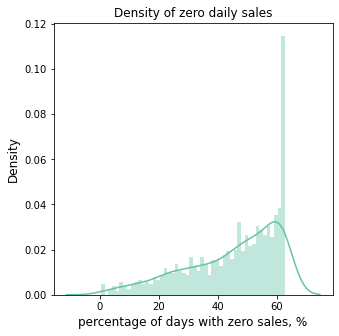

In [68]:
fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(zeros_sales_per_by_item, bins = 50)

ax.set_title('Density of zero daily sales',  fontsize=12)
ax.set_xlabel('percentage of days with zero sales, %',  fontsize=12)
ax.set_ylabel("Density", fontsize = 12)

## Average Sales

In [48]:
nonzeros_sales = df[df['sold']>0]

avg_daily_sales = nonzeros_sales.groupby('id')['sold'].mean().reset_index()

avg_daily_sales.head()



,id,sold
0,FOODS_1_001_TX_2_validation,1.694323
1,FOODS_1_013_TX_3_validation,1.880000
2,FOODS_1_018_CA_4_validation,6.176142
3,FOODS_1_020_CA_3_validation,1.646104
4,FOODS_1_024_WI_2_validation,1.559671


C:\Users\DIEGO UNZUETA\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



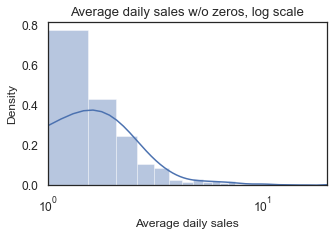

In [50]:
fig, ax = plt.subplots(figsize = (5,3))
sns.distplot(avg_daily_sales[avg_daily_sales['sold']<=50]['sold'])

ax.set_title('Average daily sales w/o zeros, log scale')
ax.set_xlabel('Average daily sales', fontsize = 12)
ax.set_ylabel("Density", fontsize = 12)
ax.set_xscale('log')
ax.set_xlim(1, 20)
plt.savefig("Images/Averagedailysales.png")

## 4.1 Average Sales between items

Text(0, 0.5, 'Average sales')

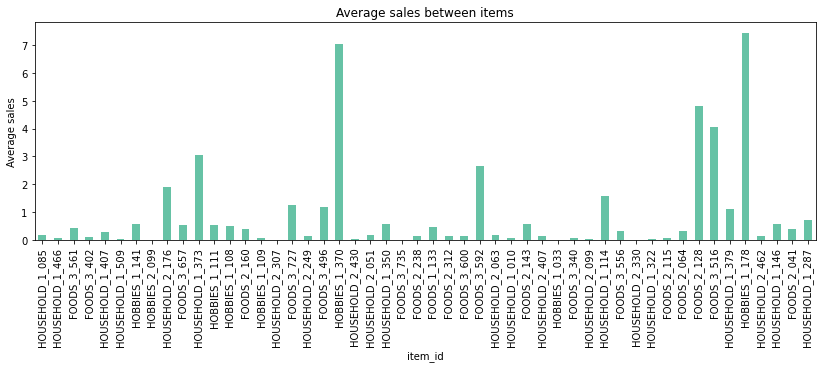

In [44]:
daily_sale_by_rand_store, _ = getDailySaleByStore()

f, ax = plt.subplots(figsize=(14, 4))
daily_sale_by_rand_store.groupby('item_id')['sold'].mean().sample(50).plot(kind='bar')
ax.set_title('Average sales between items')
ax.set_ylabel('Average sales')


- It’s clear that the sales between different items are different, which is in line with our common sense

## 4.2 Distribution of total sales by category


[Text(0.5, 1.0, 'Total sales by category')]

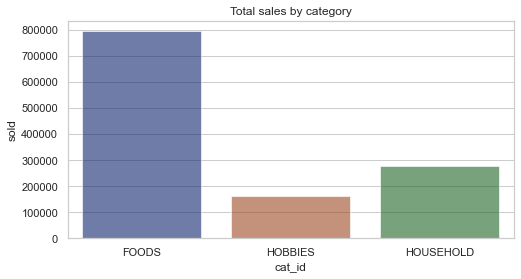

In [97]:
sales_group_by_cate = df.groupby(['cat_id'])['sold'].sum().reset_index()

fig, ax = plt.subplots( figsize=(8,4))
g = sns.barplot(
    data=sales_group_by_cate,
    x="cat_id", y="sold", 
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Total sales by category')


- Food category has the largest sales followed by household and hobbies on the whole.

## 4.2 Total Daily sales trend by category


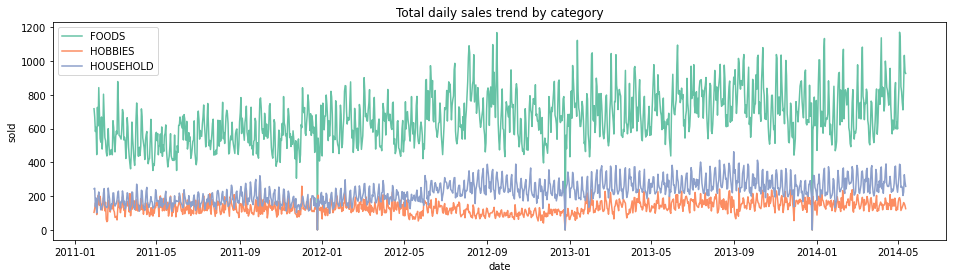

In [46]:
fig, ax = plt.subplots(figsize=(16, 4))
avg_sales_group_by_cate_daily = df.groupby(['cat_id', 'date'])['sold'].sum().reset_index()

gi = sns.lineplot(
    data=avg_sales_group_by_cate_daily,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Total daily sales trend by category')
gi.legend(loc="upper left")


- Food category has the highest sales than the others.
 
 
- It looks like the sales decrease a lot at the end of the year.
 
 
- The sales on ‘Hobbies’ don't change a lot over the years.


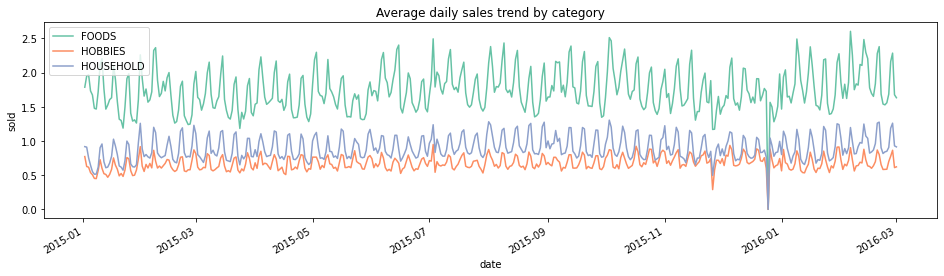

In [466]:
import matplotlib.dates as mdates

mask = (df['date'] > '2015-1-1') & (df['date'] <= '2016-3-1')
avg_sales_group_by_cate_year_month = df.loc[mask].groupby(['cat_id', 'date'])['sold'].mean().reset_index()


fig, ax = plt.subplots(figsize=(16, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_year_month,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Average daily sales trend by category')
gi.legend(loc="upper left")

# set ticks every week
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate() # Rotation


### Christmas Day

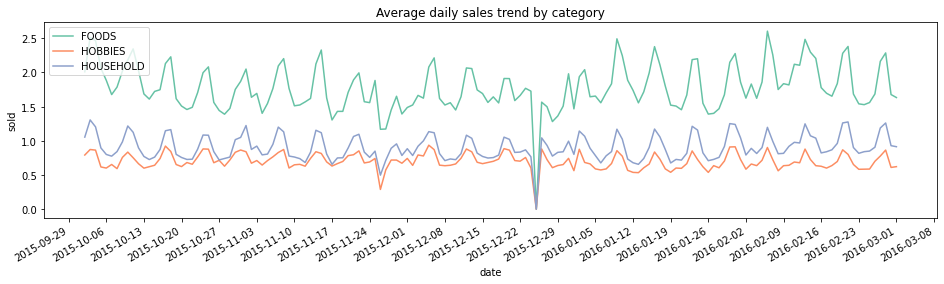

In [464]:
import matplotlib.dates as mdates

mask = (df['date'] > '2015-10-1') & (df['date'] <= '2016-3-1')
avg_sales_group_by_cate_year_month = df.loc[mask].groupby(['cat_id', 'date'])['sold'].mean().reset_index()


fig, ax = plt.subplots(figsize=(16, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_year_month,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Average daily sales trend by category')
gi.legend(loc="upper left")

# set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate() # Rotation


- There is some weekly pattern.


- The sales before Christmas don’t increase much as we expect. On the contrary, more items are sold after Christmas, especially during the following 2 weeks.


- TODO: Do other holidays have the same pattern?



In [497]:
df["week"] = df["date"].dt.week.astype("int8")

df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week
0,FOODS_3_035_WI_1_validation,FOODS_3_035,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
1,FOODS_3_519_CA_4_validation,FOODS_3_519,FOODS_3,FOODS,CA_4,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
2,FOODS_3_545_CA_3_validation,FOODS_3_545,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
3,HOUSEHOLD_1_314_TX_3_validation,HOUSEHOLD_1_314,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
4,HOBBIES_1_214_CA_3_validation,HOBBIES_1_214,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4


## 4.3 Distribution of  average monthly sales by category


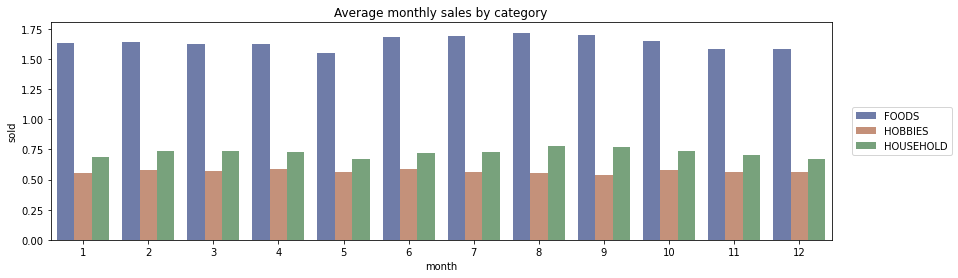

In [429]:
avg_sales_group_by_cate_month = df.groupby(['month', 'cat_id'])['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14,4))
g = sns.barplot(
    data=avg_sales_group_by_cate_month,
    x="month", y="sold", hue="cat_id",
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Average monthly sales by category')
g.legend(loc='center right', bbox_to_anchor=(1.16, 0.5), ncol=1)


- Food category has the largest sales across all the months, followed by hobbies and household.

- The average sales are more or less constant between 12 months.


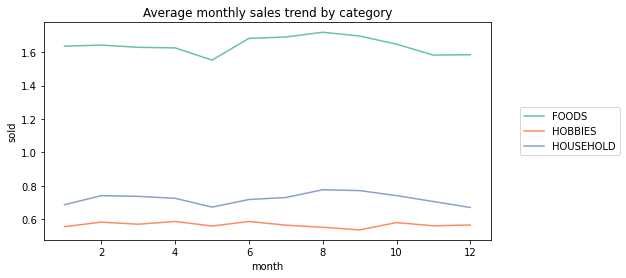

In [433]:
fig, ax = plt.subplots(figsize=(8, 4))
avg_sales_group_by_cate_daily = df.groupby(['cat_id', 'month'])['sold'].mean().reset_index()

gi = sns.lineplot(
    data=avg_sales_group_by_cate_daily,
    x="month", y="sold", 
    hue='cat_id'
)
gi.set(title='Average monthly sales trend by category')
gi.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)


- There is a decrease from January to the end of April, after that, the sales increase until the end of September.


- TODO: compare sales by season



## 4.4 Distribution of average weekday  sales by category


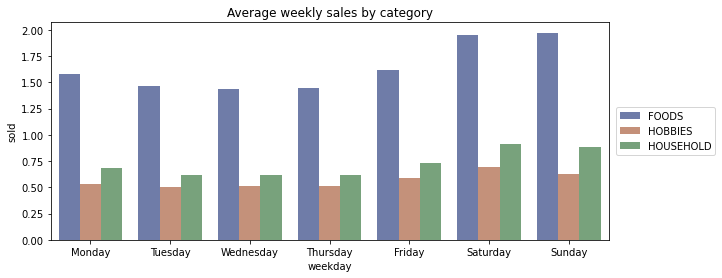

In [428]:

avg_sales_group_by_cate_weekday = df.groupby(['weekday', 'cat_id'])['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,4))

g = sns.barplot(
    data=avg_sales_group_by_cate_weekday,
    x='weekday', y="sold", hue="cat_id",
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Average weekly sales by category')
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)


- There are more sales on Saturday and Sunday.

- Therea are fewer sale on Wednesday and Thurday.


In [34]:
sns.set_style("white")

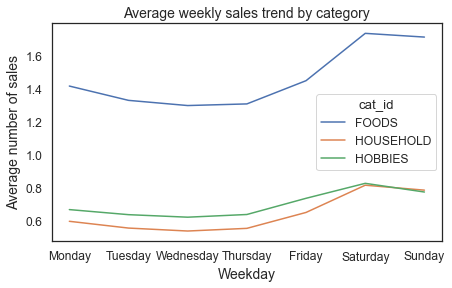

In [46]:
from pandas.api.types import CategoricalDtype
sns.set(font_scale = 1.1)
sns.set_style("white")
avg_sales_group_by_cate_weekly = df.groupby(['cat_id', 'weekday'])['sold'].mean().reset_index()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
avg_sales_group_by_cate_weekly['weekday'] = avg_sales_group_by_cate_weekly['weekday'].astype(cat_type)
avg_sales_group_by_cate_weekly = avg_sales_group_by_cate_weekly.sort_values('weekday')
avg_sales_group_by_cate_weekly.head()

fig, ax = plt.subplots(figsize=(7, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_weekly,
    x="weekday", y="sold", 
    sort=False,
    hue='cat_id'
)

gi.grid(False)
gi.set_xlabel("Weekday", fontsize = 14)
gi.set_ylabel("Average number of sales", fontsize = 14)
#gi.set_xticklabels(ax.get_xticklabels(), rotation=-20, ha='left')
gi.set_title("Average weekly sales trend by category", fontsize = 14)
# gi.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
# gi.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.savefig("Images/Averageweeklysales.png")

There are more sales on Saturday and Sunday.

There are fewer sales on Wednesday and Thursday.


## 4.5 Sales trend of a single item

### Overall trend

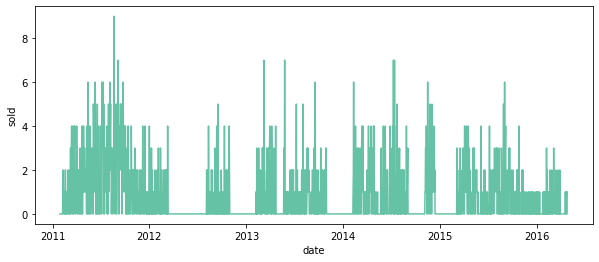

In [574]:
def dailyTrendbyId(Id):
    item_daily = df[df['id'] == Id]    

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(
        data=item_daily,
        x="date", y="sold"
    )

dailyTrendbyId('FOODS_2_092_CA_1_validation')

### Tredn By store

In [35]:
# randomly pick an item to look at its daily sale
item_daily_sale, item_id = getDailySaleByItem('HOBBIES_1_001')

# check
item_daily_sale[item_daily_sale['store_id'] == 'CA_1']


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
9096,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
39586,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
70076,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
100566,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
131056,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
...,...,...,...,...,...,...,...,...
58184016,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1909,1
58214506,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1910,3
58244996,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1911,0
58275486,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1912,1


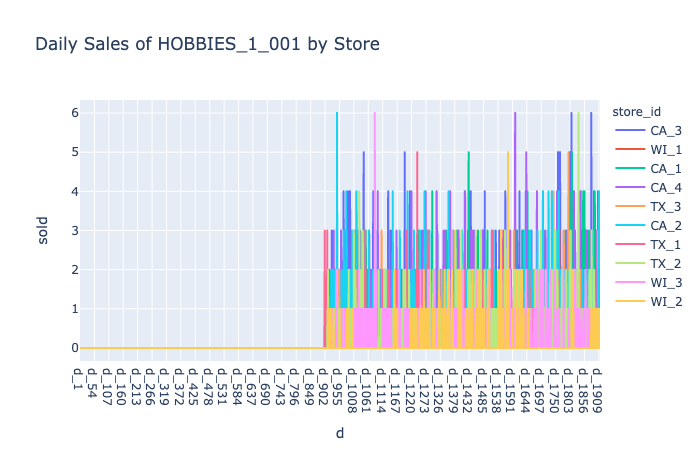

/Users/wuxiaopan/work/GroupWork/AML/HelperFunctions.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



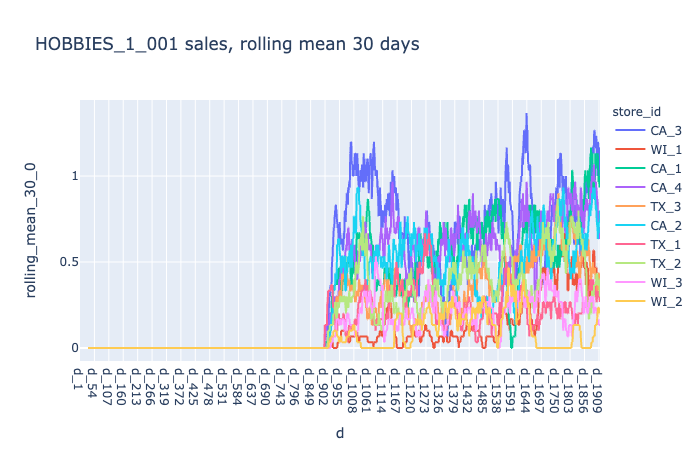

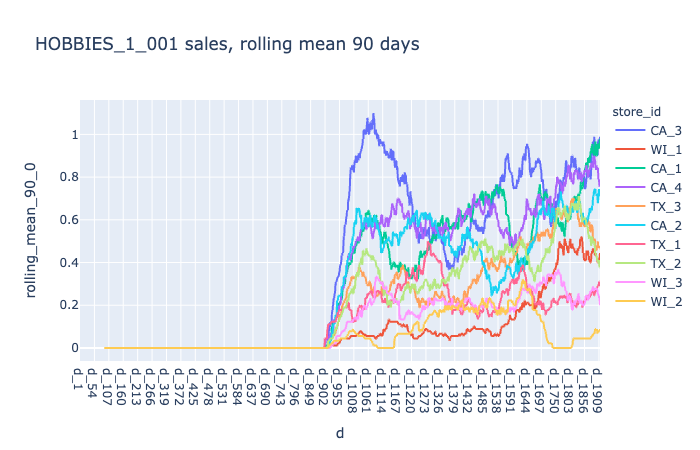

In [36]:
fig = px.line(
    item_daily_sale, 
    x=time_unit, y='sold', color='store_id', 
    title='Daily Sales of ' + item_id + ' by Store')

fig.show()

# rolling
window_size = [30, 90]
shift=0
for s in window_size:
    item_daily_sale_rolling = hf.rollingMeanDemandFeature(item_daily_sale, s, shift)
    fig = px.line(
        item_daily_sale_rolling, 
        x=time_unit, y='rolling_mean_' + str(s)+'_'+str(shift), color='store_id', 
        title=item_id + ' sales, rolling mean ' + str(s) + ' days')
    fig.show()



### Sale Trend Summary

- Some items don't have sales until some day(e.g. d_900)


- The sale pattern is clear in seasonal sales.


- Sales are very low.


# 5. Sales by Store


## 5.1 Total sales between all the stores

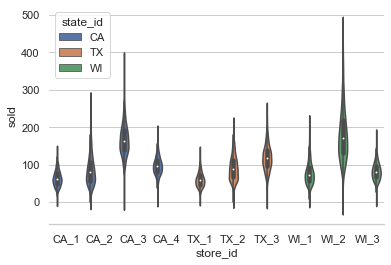

In [98]:
group = df.groupby(['d', 'state_id', 'store_id'], as_index=False)['sold'].sum().dropna()

fig, ax = plt.subplots()
sns.set_theme(style="whitegrid")
sns.violinplot(data=group, x="store_id", y="sold", hue="state_id")
sns.despine(left=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()


- Different stores have different sales, and ‘CA_3' has the highest sales while 'CA_4' has the smallest among all the stores. So the sales are somehow related to the store.



## 5.2 Total sales by Category between all the stores

In [53]:
sales_group_by_store_cate = df.groupby(['store_id', 'cat_id'])['sold'].sum().reset_index()


[Text(0.5, 1.0, 'Total sales by store')]

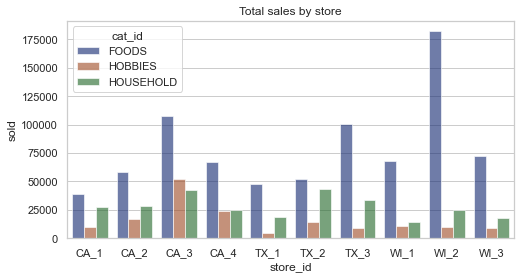

In [54]:
fig, ax = plt.subplots(figsize=(8,4))

g = sns.barplot(
    data=sales_group_by_store_cate,
    x="store_id", y="sold", hue="cat_id",
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Total sales by store')


- Food has the largest sales followed by household and hobbies across all the stores.


- Hobbies category seems to have small changes between the three stores while the other two change a lot.


## 5.3 Total Daily Sales Trend by Category between all the stores

In [366]:
sale_by_date_cat_store = df.groupby(['store_id', 'cat_id', 'date'])['sold'].sum().reset_index()

sale_by_date_cat_store.head()


,store_id,cat_id,date,sold
0,CA_1,FOODS,2011-01-29,3239
1,CA_1,FOODS,2011-01-30,3137
2,CA_1,FOODS,2011-01-31,2008
3,CA_1,FOODS,2011-02-01,2258
4,CA_1,FOODS,2011-02-02,2032


<ipython-input-467-5aa2b14742fd>:20: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



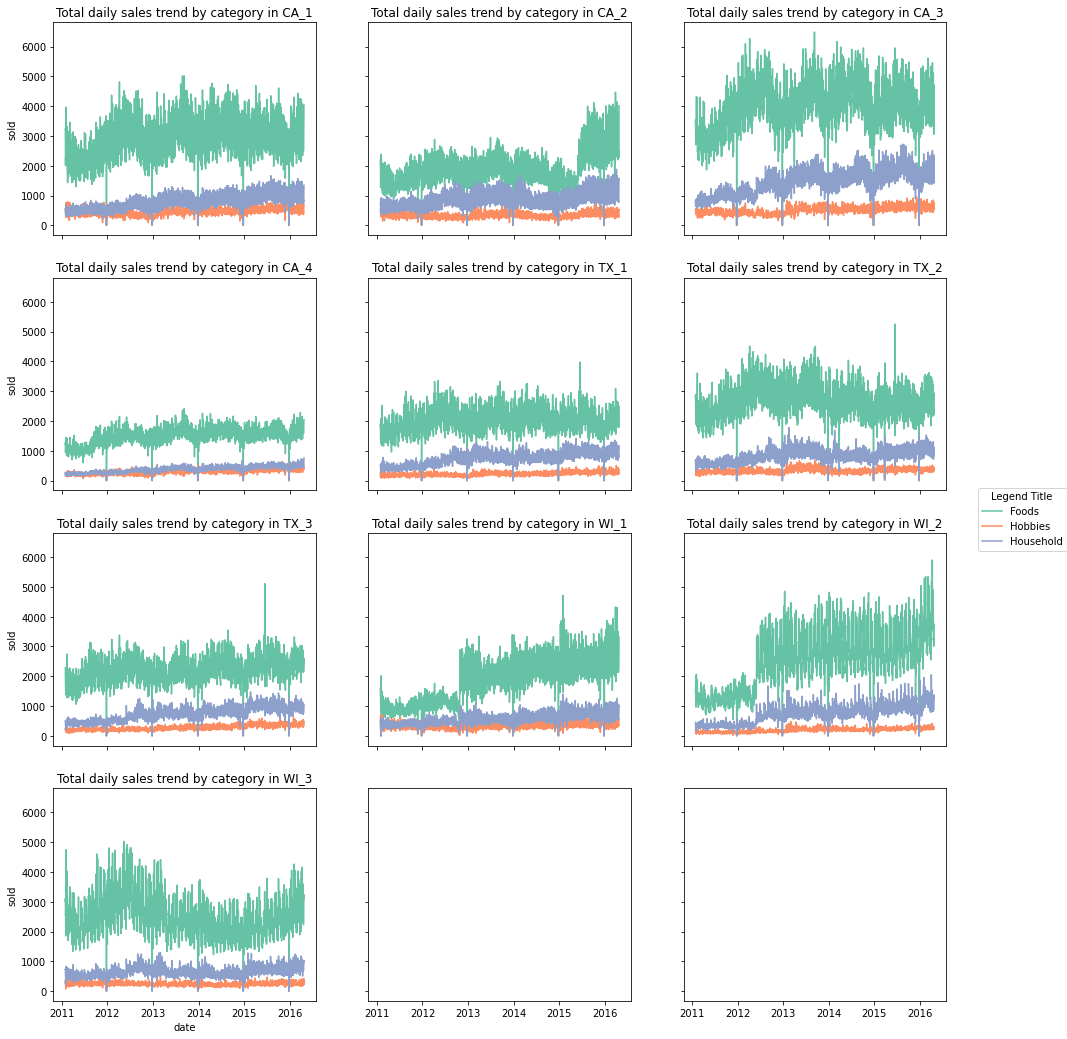

In [467]:
fig, ax = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(16, 18))
stores = df_sales['store_id'].unique()
g=[]
line_labels = ['Foods', 'Hobbies', 'Household']

for (i, s) in enumerate(stores):
    store_sales = sale_by_date_cat_store.loc[sale_by_date_cat_store['store_id'] == s]
    gi = sns.lineplot(
        data=store_sales,
        x="date", y="sold", 
        hue='cat_id', 
        ax=ax[i//3, i%3]
    )
    gi.set(title='Total daily sales trend by category in ' + s)
    g.append(gi)

for gi in g:
    gi.get_legend().remove()

fig.legend(g, 
    labels=line_labels, 
    loc="center right", 
    borderaxespad=0.1, 
    title="Legend Title"
)


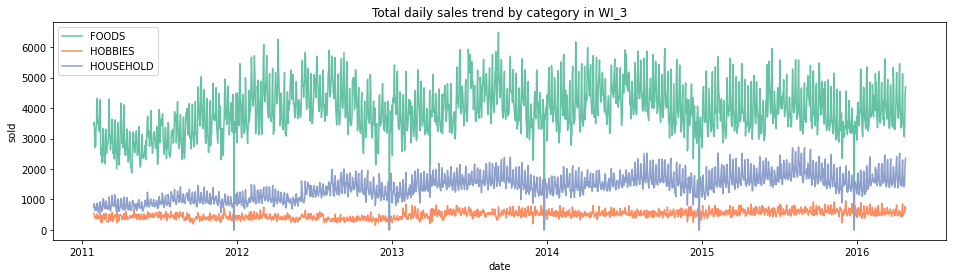

In [468]:
fig, ax = plt.subplots(figsize=(16, 4))
stores = df_sales['store_id'].unique()

one_store_sales = sale_by_date_cat_store.loc[sale_by_date_cat_store['store_id'] == np.random.choice(stores)]
gi = sns.lineplot(
    data=one_store_sales,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Total daily sales trend by category in ' + s)
gi.legend(loc="upper left")


- It looks like the sales decrease a lot at the end of the year.


## 5.4 Average Monthly Sales Trend by Category between all the stores

In [477]:
sale_by_month_cat_store = df.groupby(['store_id', 'cat_id', 'month'])['sold'].mean().reset_index()

sale_by_month_cat_store.head()


,store_id,cat_id,month,sold
0,CA_1,FOODS,1,1.890524
1,CA_1,FOODS,2,1.889877
2,CA_1,FOODS,3,1.910125
3,CA_1,FOODS,4,1.969373
4,CA_1,FOODS,5,1.940153


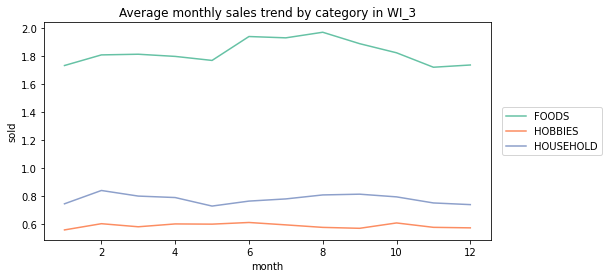

In [489]:
stores = df_sales['store_id'].unique()

one_store_month_sales = sale_by_month_cat_store.loc[sale_by_month_cat_store['store_id'] == np.random.choice(stores)]

fig, ax = plt.subplots(figsize=(8, 4))
gi = sns.lineplot(
    data=one_store_month_sales,
    x="month", y="sold", 
    hue='cat_id'
)
gi.set(title='Average monthly sales trend by category in ' + s)
gi.legend(loc='center right', bbox_to_anchor=(1.26, 0.5), ncol=1)

## 5.5 Average weekday sales trend by category between the stores



<ipython-input-492-ee1460d2517c>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



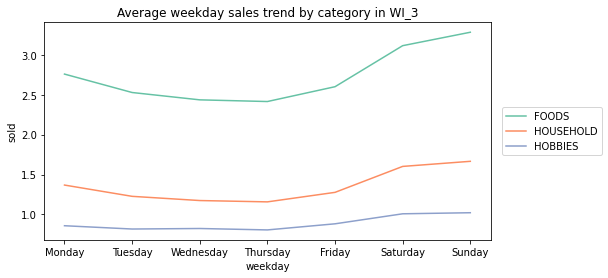

In [492]:
from pandas.api.types import CategoricalDtype

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sale_by_weekday_cat_store = df.groupby(['store_id', 'cat_id', 'weekday'])['sold'].mean().reset_index()

stores = df_sales['store_id'].unique()
one_store_weekday_sales = sale_by_weekday_cat_store.loc[sale_by_weekday_cat_store['store_id'] == np.random.choice(stores)]

cat_type = CategoricalDtype(categories=cats, ordered=True)
one_store_weekday_sales['weekday'] = one_store_weekday_sales['weekday'].astype(cat_type)
one_store_weekday_sales = one_store_weekday_sales.sort_values('weekday')



fig, ax = plt.subplots(figsize=(8, 4))
gi = sns.lineplot(
    data=one_store_weekday_sales,
    x="weekday", y="sold", 
    hue='cat_id'
)
gi.set(title='Average weekday sales trend by category in ' + s)
gi.legend(loc='center right', bbox_to_anchor=(1.26, 0.5), ncol=1)



# 6. Sale vs Snap




<AxesSubplot:xlabel='snap_WI', ylabel='count'>

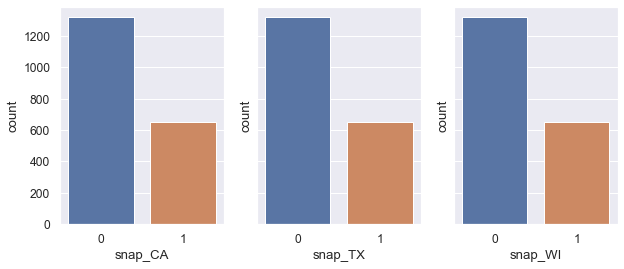

In [114]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

sns.countplot(x="snap_CA", data=calendar, ax=axs[0])
sns.countplot(x="snap_TX", data=calendar, ax=axs[1])
sns.countplot(x="snap_WI", data=calendar, ax=axs[2])
# fig.set(title='ds')

- The distributions of snap are similar between the three stores.


- One third of the total days are days that is allowd to use vourcher.


[Text(0.5, 1.0, 'Distribution of snap_WI by year')]

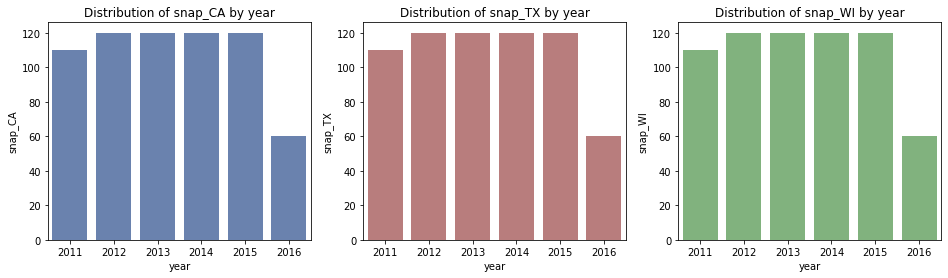

In [588]:

year_snap = calendar.groupby(['year'])[['snap_CA', 'snap_TX', 'snap_WI']].sum().reset_index()

fig, ax = plt.subplots(1, 3, figsize=(16,4))

sns.set_color_codes("muted")
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_CA",
    color="b", saturation=.5,
    ax=ax[0]
)
g.set(title='Distribution of snap_CA by year')
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_TX",
    color="r", saturation=.5,
    ax=ax[1]
)
g.set(title='Distribution of snap_TX by year')
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_WI",
    color="g", saturation=.5,
    ax=ax[2]
)
g.set(title='Distribution of snap_WI by year')




[Text(0.5, 1.0, 'Distribution of snap_WI by month, 2011')]

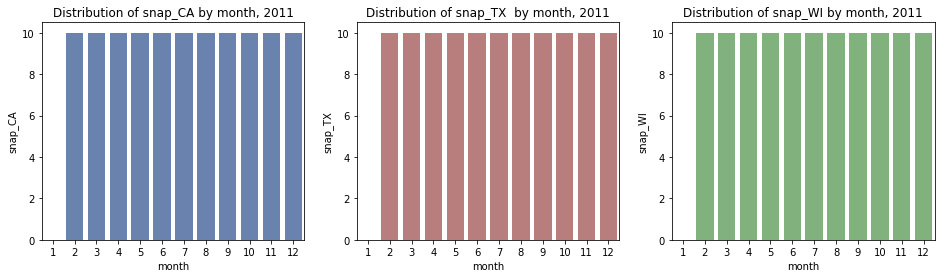

In [606]:

year_month_snap = calendar.groupby(['year', 'month'])[['snap_CA', 'snap_TX', 'snap_WI']].sum().reset_index()
rand_year = np.random.choice(calendar['year'].unique())
year_month_snap = year_month_snap[year_month_snap['year'] == rand_year]

fig, ax = plt.subplots(1, 3, figsize=(16,4))
sns.set_color_codes("muted")
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_CA",
    color="b", saturation=.5,
    ax=ax[0]
)
g.set(title='Distribution of snap_CA by month, ' + str(rand_year))
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_TX",
    color="r", saturation=.5,
    ax=ax[1]
)
g.set(title='Distribution of snap_TX  by month, ' + str(rand_year))
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_WI",
    color="g", saturation=.5,
    ax=ax[2]
)
g.set(title='Distribution of snap_WI by month, ' + str(rand_year))



- There are 10 days that vouchers are allowed every month in each state


In [696]:
# fig, ax = plt.subplots(4, 3, figsize=(16, 16))
# year = 2011
# for i in range(12):
#     if i == 11:
#         a = str(i + 1)
#         b = '1'
#         next_year = year + 1
#     else:
#         a = str(i + 1)
#         b = str(i + 2)
#         next_year = year
#     mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(next_year)+'-' + b + '-1')
#     snap_year = calendar.loc[mask]
# #     print(snap_year[snap_year['snap_CA'] == 1]['date'])
#     sns.scatterplot(data=snap_year, x="date", y="snap_CA", ax=ax[i//3, i%3])
#     plt.gcf().autofmt_xdate() # Rotation


- The distribution of the days that vouchers are allowed to share the same pattern every month for every state.


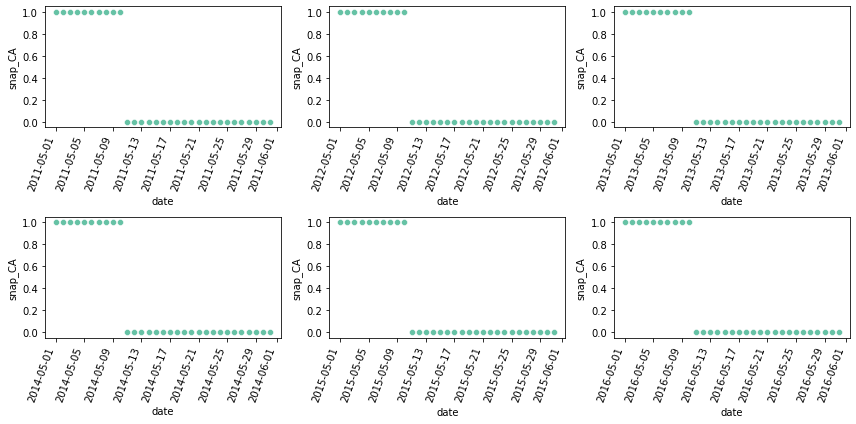

In [690]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_CA", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


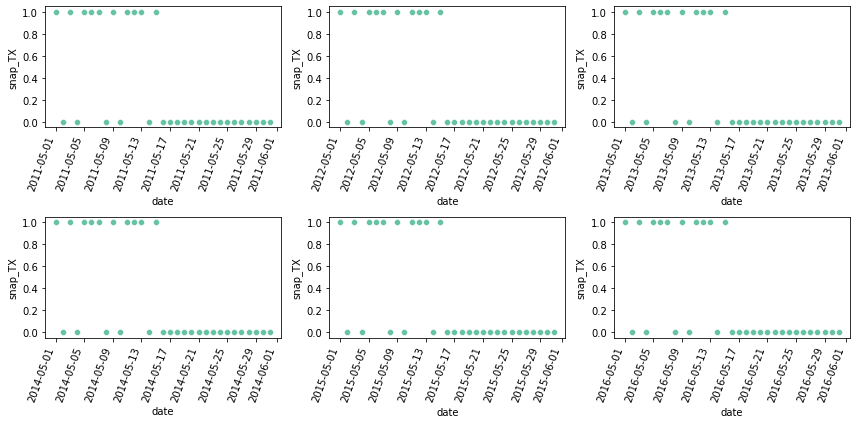

In [691]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_TX", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


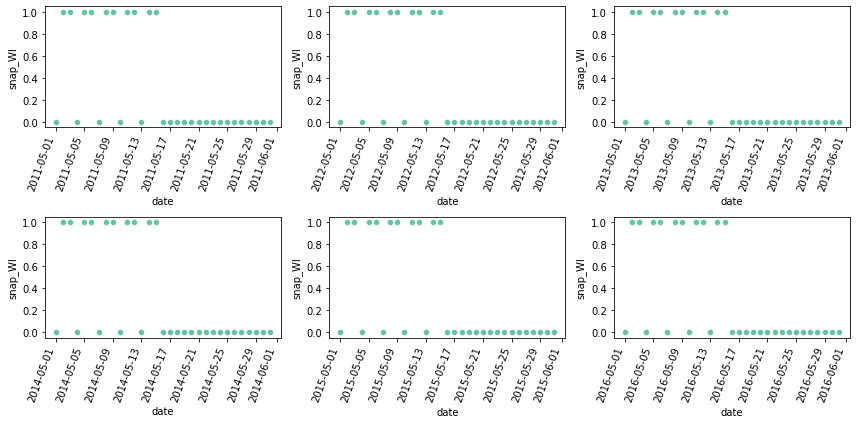

In [692]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_WI", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


## Do the sales increase on the Snap day?


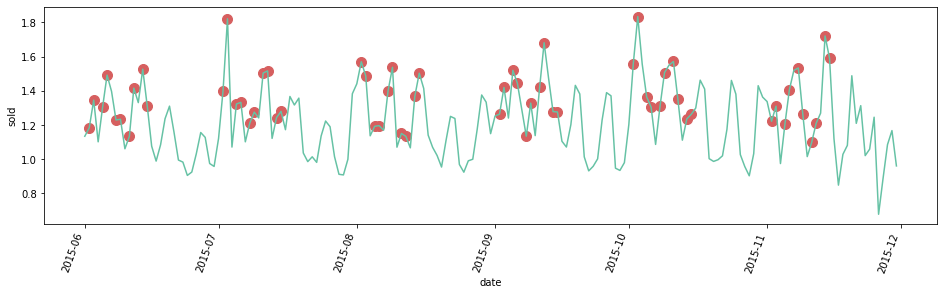

In [836]:
year = 2015
am = '6'
bm = '12'
state_id = 'WI'
mask = (df['date'] >= str(year)+'-' + am + '-1') & (df['date'] < str(year)+'-' + bm + '-1')

sale_rand_year = df.loc[mask]
sale_rand_year = sale_rand_year[sale_rand_year['state_id'] == state_id]
sale_rand_year_date = sale_rand_year.groupby('date')['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(data=sale_rand_year_date, x='date', y='sold', ax=ax)
mask_s = sale_rand_year.groupby('date')['snap_' + state_id].mean()
for i, snaped in enumerate(pd.DataFrame(mask_s)['snap_' + state_id]):
    if snaped == 1:
        ax.scatter(x=sale_rand_year_date.iloc[i]['date'], y=sale_rand_year_date.iloc[i]['sold'], c='r', s=100)
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.show()


[[0.9846806569343066, 0.8654080287496746, 1.0668363338229767], [1.065772506082725, 1.0001353569192766, 1.370732085082949]]


C:\Users\DIEGO UNZUETA\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



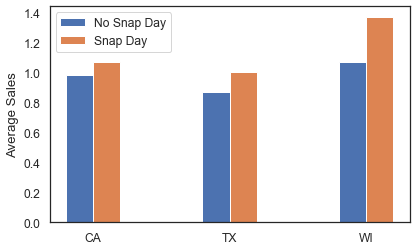

In [60]:
import numpy as np
import matplotlib.pyplot as plt

names =['CA', 'TX', 'WI']
snaps = []
for snap in range(2):
#     print(snap)
    for i, state_id in enumerate(['CA', 'TX', 'WI']):
        sales_WI_snap = df[df['state_id'] == state_id]
        g_sales_WI_snap = sales_WI_snap.groupby('snap_' + state_id)['sold'].mean().reset_index()
#         print(g_sales_WI_snap.values)
        snaps.append(g_sales_WI_snap.values[snap][1])
#     print(snaps)
#         snap.append(sum(g_sales_WI_snap[])
snaps = [snaps[:3], snaps[3:]]
print(snaps)
X = np.arange(3)
fig = plt.figure(figsize = (5,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, snaps[0], width = 0.20, label = "No Snap Day")
ax.bar(X + 0.20, snaps[1],  width = 0.20, label = "Snap Day")

ax.grid(False)
x = np.arange(len(names))+0.1 # the label locations
ax.set_xticks(x)
ax.set_xticklabels(names)
plt.ylabel("Average Sales")
plt.legend()
plt.tight_layout()
plt.savefig("Images/snapevents.png")

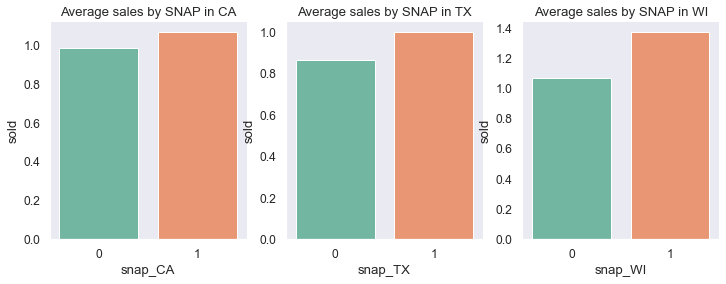

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.set_palette('Set2')

for i, state_id in enumerate(['CA', 'TX', 'WI']):
    sales_WI_snap = df[df['state_id'] == state_id]
    g_sales_WI_snap = sales_WI_snap.groupby('snap_' + state_id)['sold'].mean().reset_index()

    sns.barplot(x='snap_' + state_id, y="sold", data=g_sales_WI_snap, ax=ax[i])
    
    total = len(g_sales_WI_snap['sold'])
    for p in ax[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.4
        y = p.get_y() + p.get_height()
#         ax[i].annotate(percentage, (x, y))
        ax[i].set_title('Average sales by SNAP in '+ state_id)
        ax[i].grid(False)

sns.despine(bottom = False, left = False)
plt.show()

# 7、Sales by Event


<AxesSubplot:xlabel='event_type_2', ylabel='count'>

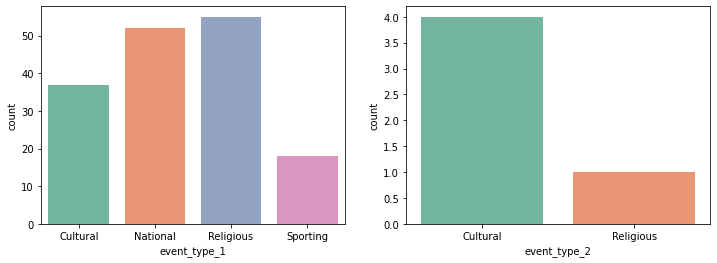

In [598]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x='event_type_1', data=calendar, ax=ax[0])
sns.countplot(x='event_type_2', data=calendar, ax=ax[1])



- Event_type_2 has fewer observations compared tp 'event_type_1' column, we can ignore it somehow.

- There are 5 days with two events.

- Many days have only one event.

- Most days have no events.


In [599]:
df["event_type_1"] = df["event_type_1"].cat.add_categories('Normal')
df["event_type_1"] = df['event_type_1'].fillna('Normal')

sales_by_event = df.groupby(['cat_id', 'event_type_1'])['sold'].mean().reset_index()


ValueError: new categories must not include old categories: {'Normal'}

In [617]:
diff_values = []
for cat in sales_by_event['cat_id'].unique():
    sales_by_event_cat = sales_by_event[sales_by_event['cat_id'] == cat]
    normal = sales_by_event_cat[sales_by_event_cat['event_type_1'] == 'Normal']['sold']
    diff_values = diff_values + (sales_by_event_cat['sold'] - normal.values).tolist()

# diff_values
sales_by_event['sold_diff'] = diff_values
sales_by_event

,cat_id,event_type_1,sold,sold_diff
0,FOODS,Cultural,1.656067,0.010623
1,FOODS,National,1.434939,-0.210505
2,FOODS,Religious,1.617023,-0.028421
3,FOODS,Sporting,1.763583,0.118139
4,FOODS,Normal,1.645444,0.000000
5,HOBBIES,Cultural,0.554710,-0.016384
6,HOBBIES,National,0.435804,-0.135290
7,HOBBIES,Religious,0.558278,-0.012817
8,HOBBIES,Sporting,0.550542,-0.020553
9,HOBBIES,Normal,0.571095,0.000000


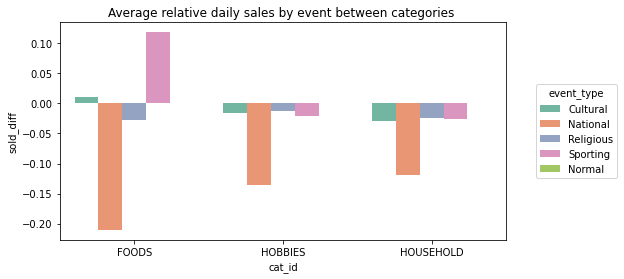

In [620]:
fig, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(
    data=sales_by_event,
    x="cat_id", y="sold_diff", hue="event_type_1" 
)

g.set(title='Average relative daily sales by event between categories ')
g.legend(title='event_type', loc='center right', bbox_to_anchor=(1.26, 0.5), ncol=1)


It seems that whether the day is holiday has little influence on the average daily sales.


# 8. Top 10 Items across the stores


In [88]:

bestseller_items = df.groupby(['item_id']).mean().sort_values(by='sold', ascending=False)


In [109]:
top10items = bestseller_items.head(10).reset_index()


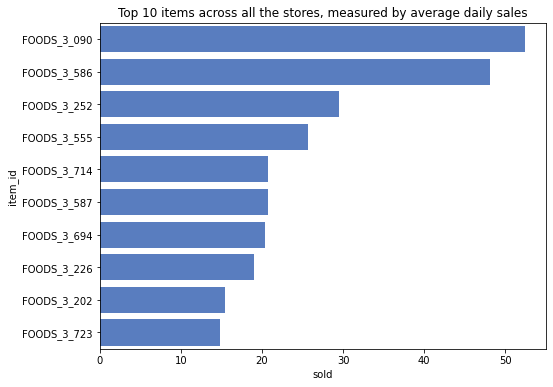

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set_color_codes("muted")
sns.barplot(data=top10items, x='sold', y='item_id', orient = "h", color='b')

ax.set_title('Top 10 items across all the stores, measured by average daily sales')
plt.show()


- The top 10 items are ‘food’ category and are from ‘Food Dept 3’.


## By store

In [127]:
sales_by_store_item = df.groupby(['store_id', 'item_id']).mean().reset_index().sort_values(by=['store_id', 'sold'], ascending=False)



In [128]:
sales_by_store_item


,store_id,item_id,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
28143,WI_3,FOODS_3_090,63.478306,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
28279,WI_3,FOODS_3_226,51.347099,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
28639,WI_3,FOODS_3_586,44.997386,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
28747,WI_3,FOODS_3_694,44.763722,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
28608,WI_3,FOODS_3_555,30.302666,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
...,...,...,...,...,...,...,...,...,...,...
908,CA_1,FOODS_3_296,0.029273,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
2762,CA_1,HOUSEHOLD_2_230,0.028228,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
1867,CA_1,HOBBIES_2_015,0.026137,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326
1462,CA_1,HOBBIES_1_026,0.010978,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326


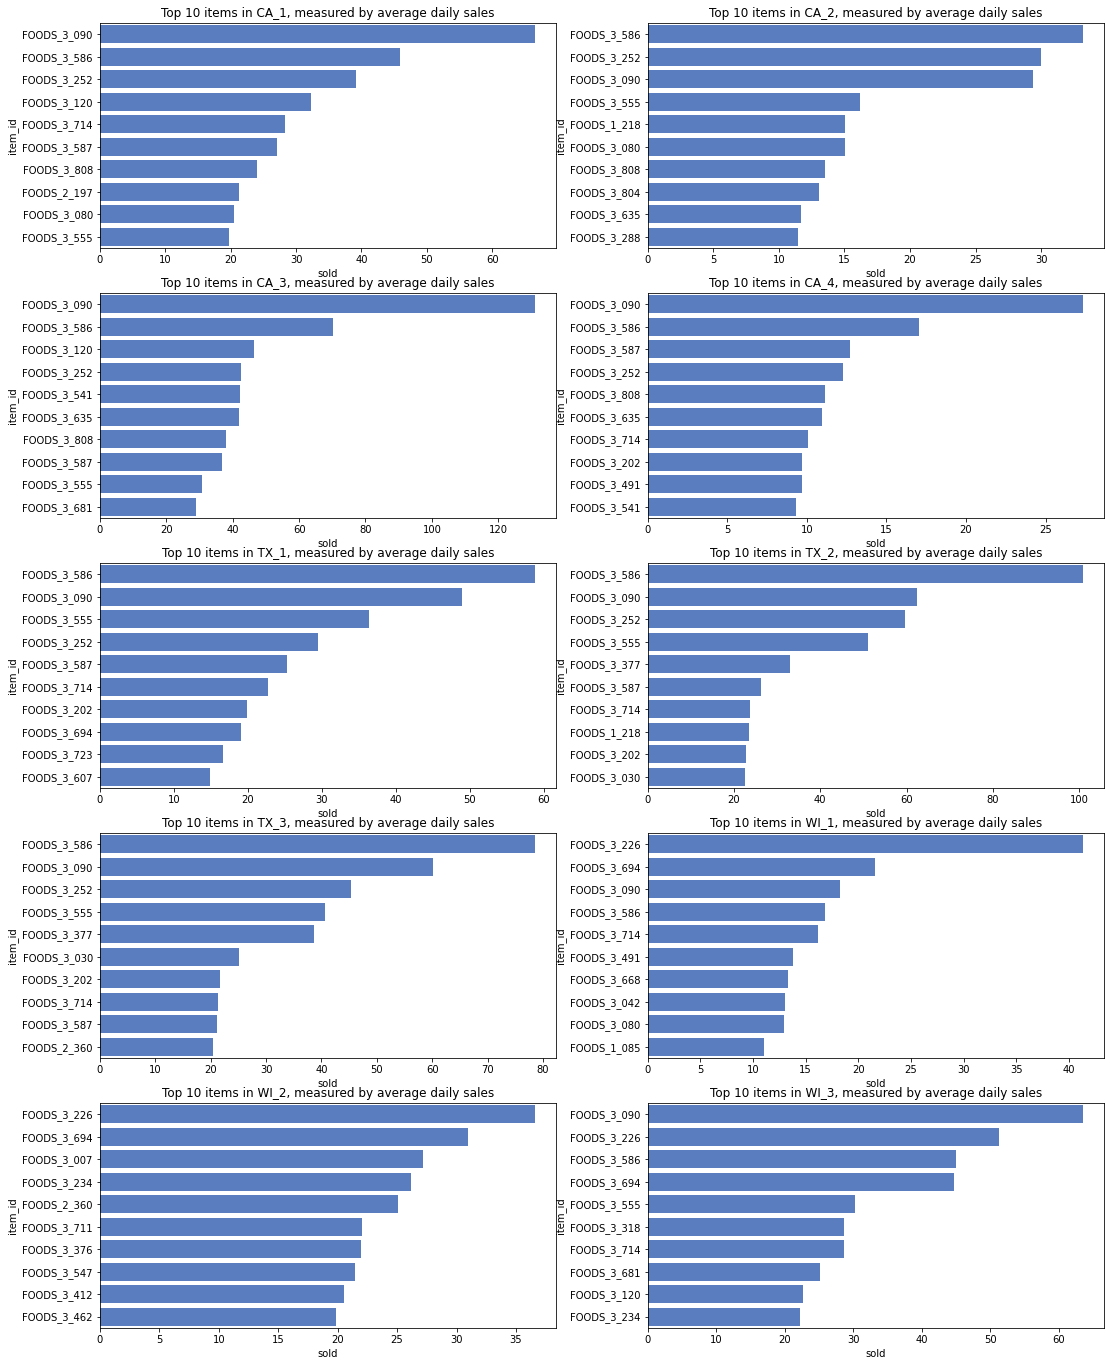

In [137]:
row = 5
col = 2

fig, axs = plt.subplots(row, col, figsize=(18, 24))
sns.set_color_codes("muted")

stores_list = df_sales['store_id'].unique()
for i, store in enumerate(stores_list):
    daily_sales_by_store = sales_by_store_item[sales_by_store_item['store_id'] == store]
    top10items = daily_sales_by_store.head(10)
    ax = axs[i//col, i%col]
    sns.barplot(data=top10items, x='sold', y='item_id', orient = "h", color='b', ax=ax)
    ax.set_title('Top 10 items in ' + store + ', measured by average daily sales')


# 9、Department

In [48]:
group = df.groupby(['d', 'state_id', 'store_id'], as_index=False)['sold'].sum().dropna()

sales_by_dept = df.groupby(['d', 'cat_id', 'dept_id'], as_index=False)['sold'].sum().dropna()


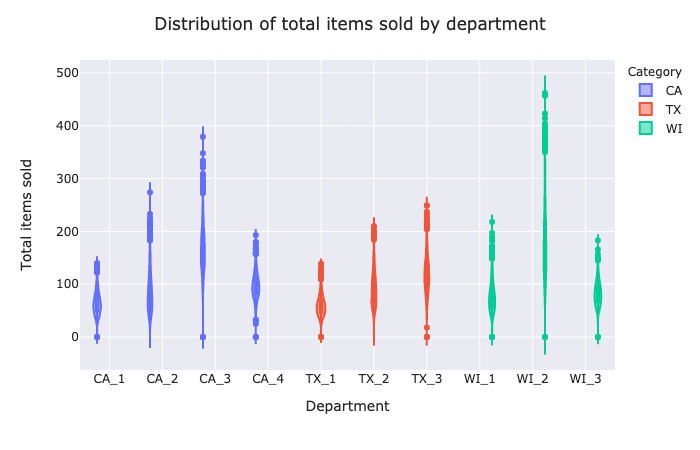

In [49]:
sales_by_dept = df.groupby(['d', 'cat_id', 'dept_id'], as_index=False)['sold'].sum().dropna()

fig = px.violin(group, x='store_id', color='state_id', y='sold', box=True)
fig.update_xaxes(title_text='Department')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of total items sold by department', legend_title_text='Category')
fig.show()


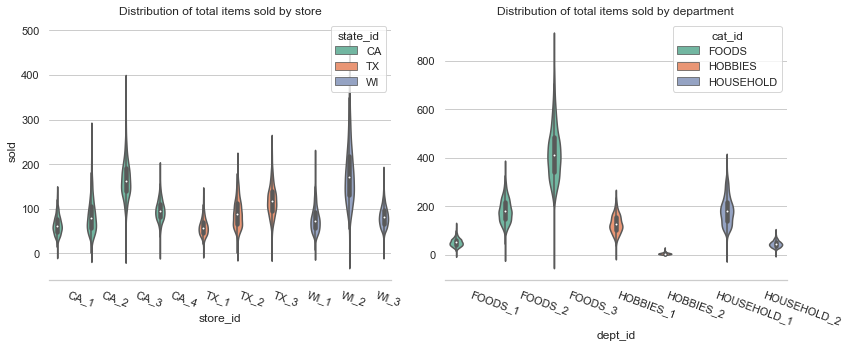

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.set_theme(style="whitegrid")
sns.set_palette('Set2')
sns.violinplot(data=group, x="store_id", y="sold", hue="state_id",ax=ax[0], inner='box')
ax[0].set_title('Distribution of total items sold by store')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20, ha='left')

sns.violinplot(data=sales_by_dept, x="dept_id", y="sold", hue="cat_id",ax=ax[1], inner='box')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-20, ha="left")
ax[1].set_title('Distribution of total items sold by department')
ax[1].set_ylabel('')

sns.despine(left=True)
plt.tight_layout()
plt.show()


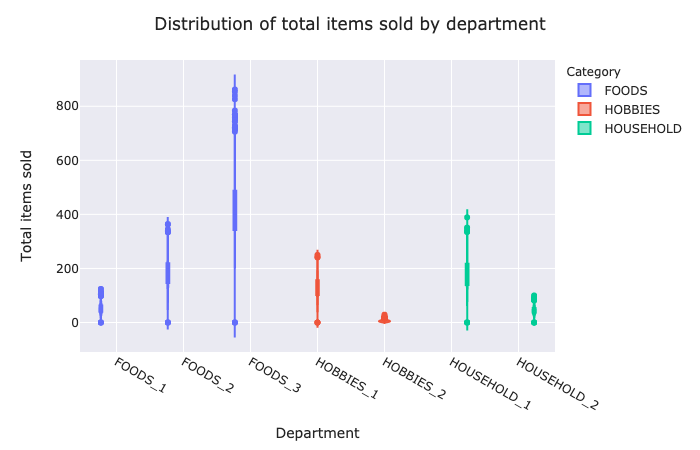

In [51]:
sales_by_dept = df.groupby(['d', 'cat_id', 'dept_id'], as_index=False)['sold'].sum().dropna()

fig = px.violin(sales_by_dept, x='dept_id', color='cat_id', y='sold', box=True)
fig.update_xaxes(title_text='Department')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of total items sold by department', legend_title_text='Category')
fig.show()


- ‘Food_3’ has the largest sales.


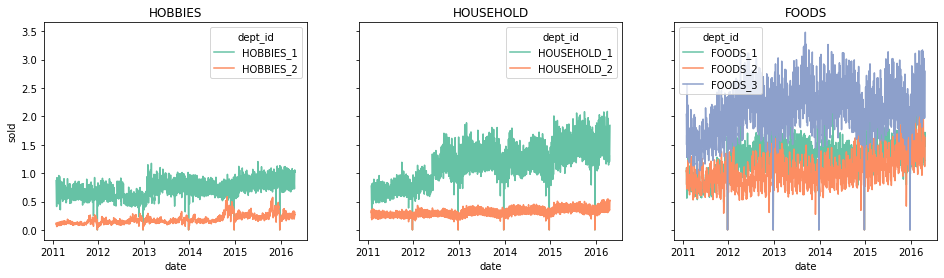

In [198]:

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for i, cate in enumerate(df_sales['cat_id'].unique()):
    cate_df = df[df['cat_id'] == cate]
    count_item_dept = cate_df.groupby(['date', 'dept_id'])['sold'].mean().reset_index()

    gi = sns.lineplot(
        data=count_item_dept,
        x="date", y="sold", 
        hue='dept_id',
        ax=ax[i]
    )
    gi.set(title=cate)


<ipython-input-209-434dba2806b3>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-209-434dba2806b3>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

<ipython-input-209-4

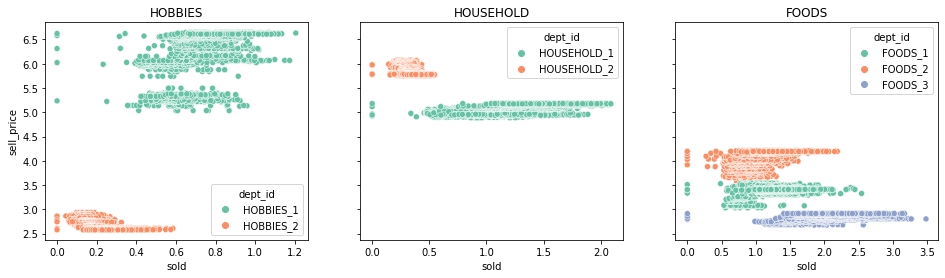

In [209]:

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for i, cate in enumerate(df_sales['cat_id'].unique()):
    cate_df = dfp[dfp['cat_id'] == cate]
    count_item_dept = cate_df.groupby(['date', 'dept_id'])['sold', 'sell_price'].mean().reset_index('dept_id')

    gi = sns.scatterplot(
        'sold','sell_price', 
        hue='dept_id', 
        data=count_item_dept,
        ax=ax[i]
    )
    gi.set(title=cate)


# 10. Correlation

In [324]:
def generate_heatmap(item_id):
    sales_by_rand_item = dfp[dfp['item_id'] == item_id]
    
    # sales_by_rand_item.loc[:, "is_event_day"] = (sales_by_rand_item["event_name_1"] != "unknown").astype("int8")
    sales_by_rand_item.loc[:, "is_sport_event"] = (sales_by_rand_item["event_type_1"] == "Sporting")
    sales_by_rand_item.loc[:, "is_cultural_event"] = (sales_by_rand_item["event_type_1"] == "Cultural")
    sales_by_rand_item.loc[:, "is_national_event"] = (sales_by_rand_item["event_type_1"] == "National")
    sales_by_rand_item.loc[:, "is_religious_event"] = (sales_by_rand_item["event_type_1"] == "Religious")

    weekday = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]
    for idx, val in enumerate(weekday):
        sales_by_rand_item.loc[:, val] = sales_by_rand_item["wday"] == idx + 1

    snap = ['snap_CA', 'snap_WI', 'snap_TX']
    for s in snap:
        sales_by_rand_item.loc[:, s] = sales_by_rand_item[s] == 1


    new_sales_by_rand_item = sales_by_rand_item.drop(columns=[
        'id', 'item_id', 
        'd', 'date', 
        'wm_yr_wk', 'weekday',
        'event_name_1', 'event_type_1',
        'event_type_2', 'event_name_2',
        'wday', 'year'
    ])


    heat_cols = new_sales_by_rand_item[[
        "sold", "sell_price", 
        "snap_CA", "snap_TX", "snap_WI", 'month', 
        "is_sport_event", "is_cultural_event", "is_national_event", "is_religious_event"] 
        + weekday]

    plt.figure(figsize=(16, 9))
    sns.heatmap(heat_cols.corr(), annot=True)

    return heat_cols
    

## heatmap

In [325]:
max_item = df[df["sold"] == df["sold"].max()]
max_item


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
29248758,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,d_960,763,2013-09-14,11334,...,1,9,2013,NaN,Normal,NaN,NaN,0,0,1


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



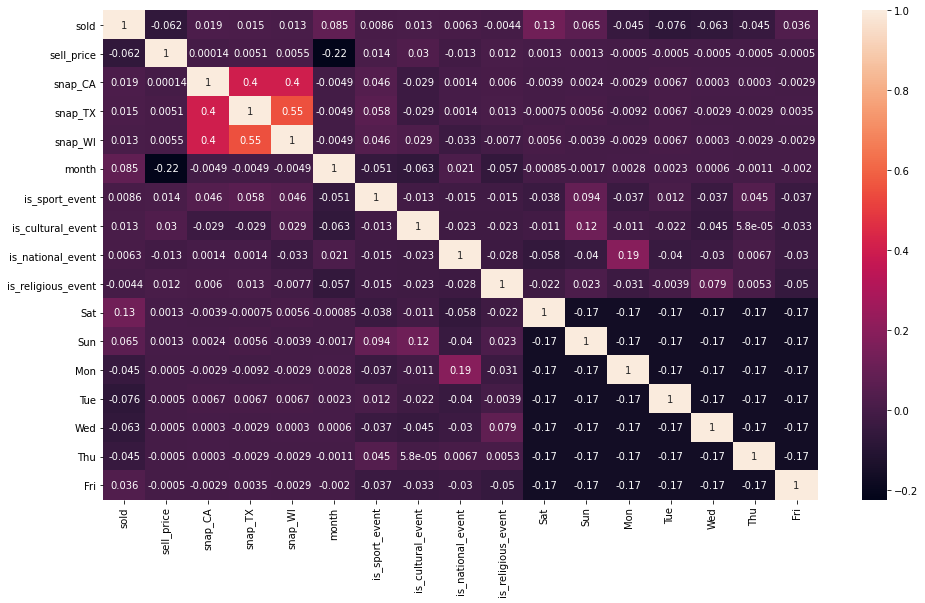

In [326]:
sale_item = generate_heatmap('FOODS_3_090')


### Random Item

In [283]:
rand_item_id = np.random.choice(df_sales['item_id'].unique())
df_sales[df_sales["item_id"] == rand_item_id].head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
2056,FOODS_2_230_CA_1_validation,FOODS_2_230,FOODS_2,FOODS,CA_1,CA,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5105,FOODS_2_230_CA_2_validation,FOODS_2_230,FOODS_2,FOODS,CA_2,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8154,FOODS_2_230_CA_3_validation,FOODS_2_230,FOODS_2,FOODS,CA_3,CA,7,7,3,5,...,0,0,0,0,0,0,0,0,0,0
11203,FOODS_2_230_CA_4_validation,FOODS_2_230,FOODS_2,FOODS,CA_4,CA,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0
14252,FOODS_2_230_TX_1_validation,FOODS_2_230,FOODS_2,FOODS,TX_1,TX,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



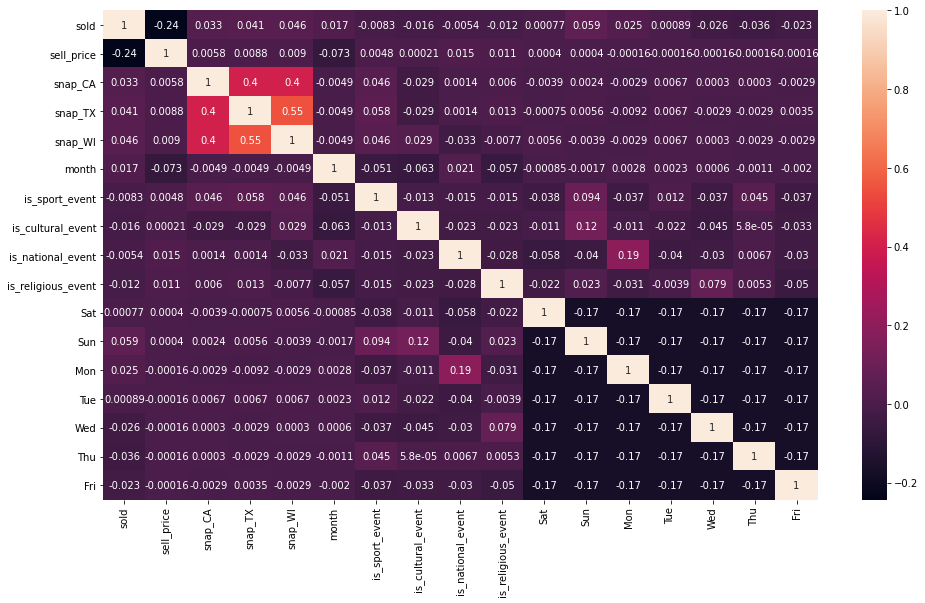

In [284]:
rand_sale_item = generate_heatmap(rand_item_id)


## DecisionTree

In [477]:
def createTree( max_depth=4):
    rand_sale_item = dfp.sample(n=500, random_state=1)

    rand_sale_item_drop = rand_sale_item.drop(columns=[
        'id', 'item_id', 'd', 'date', 'wm_yr_wk', 'wday', 'year', 
        'event_name_2', 'event_type_2',        
        'event_name_1', 'event_type_1',
        'month'
    ])

    rand_sale_item_drop = rand_sale_item_drop.dropna()
    
    rand_sale_item_dummy = pd.get_dummies(rand_sale_item_drop, columns=['cat_id', 'dept_id', 'state_id', 'store_id', 'weekday'], drop_first=True)
    
    clf = tree.DecisionTreeRegressor(max_depth=max_depth)
    clf.fit(rand_sale_item_dummy.drop(columns='sold'), rand_sale_item_dummy['sold'])

    importance = clf.feature_importances_
    features = rand_sale_item_dummy.drop(columns='sold').columns
    true_features = []
    true_importance = []
    for x in range(len(importance)):
        if importance[x] > 0:
            # print(features[x], importance[x])
            true_features.append(features[x])
            true_importance.append(importance[x])

    plt.figure(figsize=(8, 6))
    plt.bar(true_features, true_importance)
    plt.gcf().autofmt_xdate() # Rotation
#     return rand_sale_item_dummy


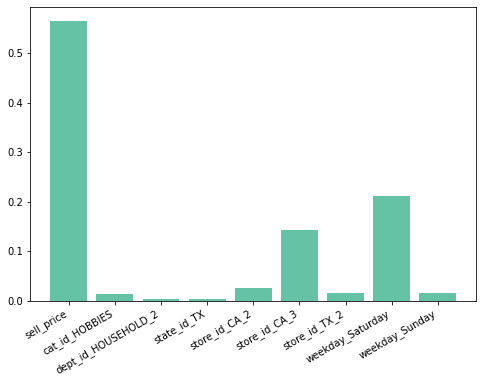

In [478]:
createTree()


#  Feature Engineering